In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

Load data, get info

In [ ]:
# Load data frame
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


Preparing data

Column verification.result has bool type we need convert it to number value

In [78]:
# Convert bool values to number values
df['verification.result'] = df['verification.result'].astype(int)
df.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,0,163.316667
1,0,0,2,1,59,2,0,0,200.860000
2,0,0,2,1,59,4,0,0,154.888889
3,0,0,2,1,59,6,0,0,108.640000
4,0,0,2,1,60,1,0,1,85.466667


For now data has no Nan values and number value

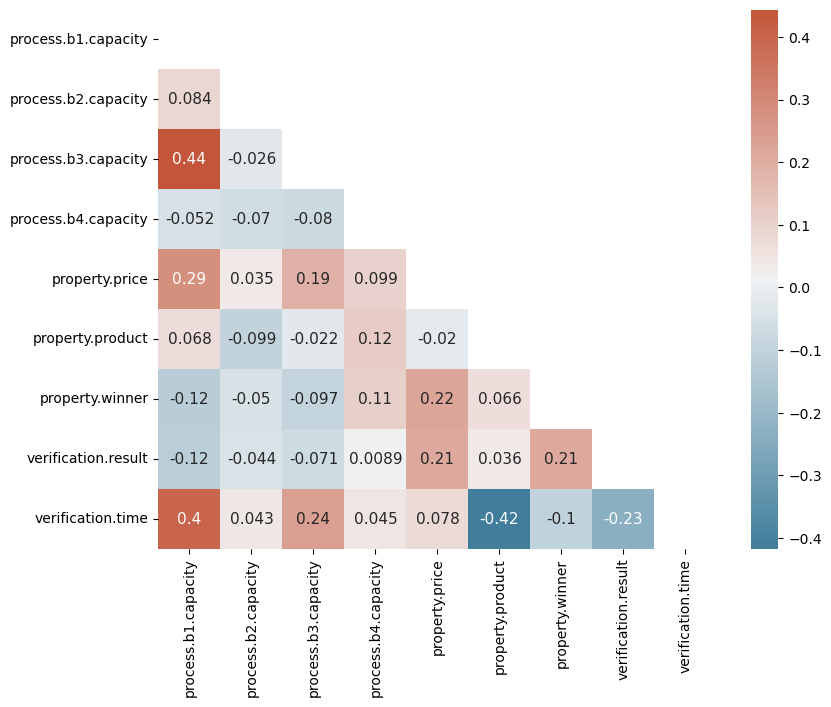

In [79]:
# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(9, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.show()

In the correlation matrix we can observe that data has acceptable values and nothing requereds to change

Add new features 


In [80]:
# Create new features 
df['d'] = df['property.price'] / df['verification.time']
df['m'] = df['verification.time'] * df['verification.result']

df.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time,d,m
0,0,0,2,1,59,1,0,0,163.316667,0.361261,0.000000
1,0,0,2,1,59,2,0,0,200.860000,0.293737,0.000000
2,0,0,2,1,59,4,0,0,154.888889,0.380918,0.000000
3,0,0,2,1,59,6,0,0,108.640000,0.543078,0.000000
4,0,0,2,1,60,1,0,1,85.466667,0.702028,85.466667


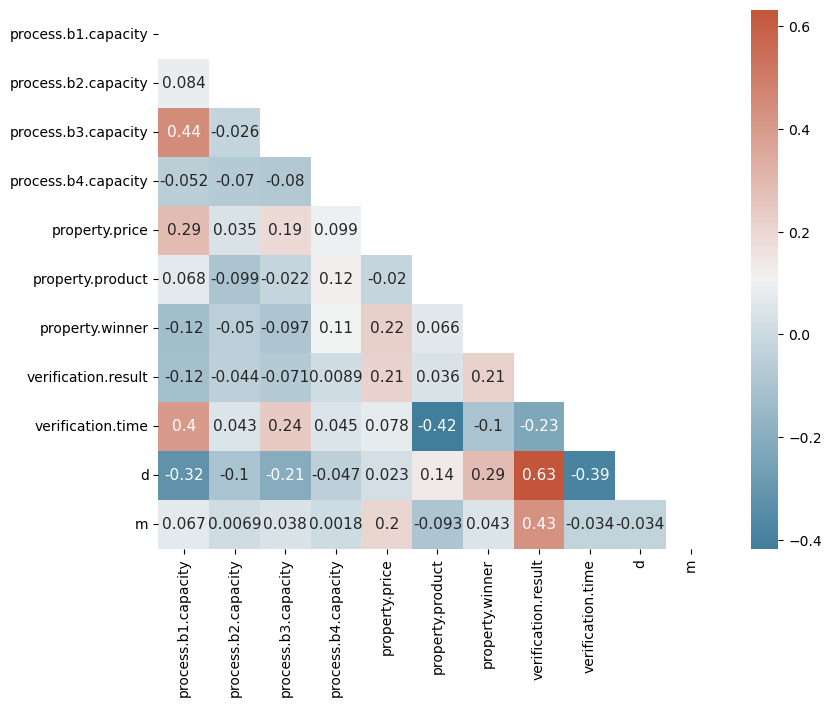

In [ ]:
# Build correlation matrix again with new features
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(9, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.show()

I added a few new features and result became much better, will see on the prediction result.

Scale and split the data


In [82]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['verification.result'])
y = df['verification.result']

In [83]:
# Scale the data using StandardScaler
scaler = MinMaxScaler()

# Scale X 
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Bagging Classifier

In [84]:
# Create a RandomForestClassifier
random_forest = RandomForestClassifier(
    n_estimators=50,        # Number of trees in the forest
    max_depth=5,            # Maximum depth of each tree
    random_state=42
)
# Create Begging Classifier
begging_clf = BaggingClassifier(
    estimator=random_forest,
    n_estimators=10,        # Number of RandomForest models in the bagging ensemble
    max_samples=0.8,        # Use 80% of the data for each random forest model
    bootstrap=True,         # Sampling with replacement
    random_state=42
)

# Perform Cross Validation
cv_sc = cross_val_score(begging_clf, X_train, y_train, cv=4)

print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [1. 1. 1. 1.]


Seems there is overfitting

In [85]:
# Train model
begging_clf.fit(X_train, y_train)

print(f'Train Score: {begging_clf.score(X_train, y_train)}')
print(f'Test Score: {begging_clf.score(X_test, y_test)}')

Train Score: 1.0
Test Score: 1.0


Train and test score equal to 1.0. We observe that Begging Clisiffire model is overfitting, even though I know that Begging Classifier works with overfitting I want to play aroung with different hyperparameters and look at the result.

In [86]:
# Create a RandomForestClassifier
random_forest = RandomForestClassifier(
    n_estimators=11,        # Number of trees in the forest
    max_depth=2,            # Maximum depth of each tree
    random_state=42
)
# Create Begging Classifier
begging_clf = BaggingClassifier(
    estimator=random_forest,
    n_estimators=10,        # Number of RandomForest models in the bagging ensemble
    max_samples=0.8,        # Use 80% of the data for each random forest model
    bootstrap=True,         # Sampling with replacement
    random_state=42
)

# Perform Cross Validation
cv_sc = cross_val_score(begging_clf, X_train, y_train, cv=4)

print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.99755501 0.97799511 0.9877451  0.99264706]


In [87]:
# Train model
begging_clf.fit(X_train, y_train)

print(f'Train Score: {begging_clf.score(X_train, y_train)}')
print(f'Test Score: {begging_clf.score(X_test, y_test)}')

Train Score: 0.9908200734394125
Test Score: 0.9926650366748166


Much better. Let's try to get metric for this model 

In [88]:
# Predict result
y_pred = begging_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       354
           1       1.00      0.95      0.97        55

    accuracy                           0.99       409
   macro avg       1.00      0.97      0.98       409
weighted avg       0.99      0.99      0.99       409

Confusion Matrix:
[[354   0]
 [  3  52]]


I've tried to descreese hyperparameters and finally we achieve ideal model when the model is not overfitting and return good metrics

Boost Classifier

In [89]:
# Create LGBMClassifier 
lgbm_clf = LGBMClassifier(
    num_leaves=31,      # Number of leaves in each tree
    max_depth=-1,       # Maximum depth of the tree (-1 means no limit)
    learning_rate=0.05, # Step size shrinking to avoid overfitting
    n_estimators=20,    # Number of boosting iterations
    random_state=42     # Random state for reproducibility
)

# Train model
lgbm_clf.fit(X_train,y_train)

# Get scoress 
print(f'Train Score: {lgbm_clf.score(X_train, y_train)}')
print(f'Test Score: {lgbm_clf.score(X_test, y_test)}')

[LightGBM] [Info] Number of positive: 207, number of negative: 1427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 1634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126683 -> initscore=-1.930611
[LightGBM] [Info] Start training from score -1.930611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Train and Test score equal 1.0 and we get the overfitting model again. Let's try to change hyperparameters, maybe it will help us.

In [ ]:
# Create LGBMClassifier 
lgbm_clf = LGBMClassifier(  
    max_depth=2,       
    learning_rate=0.01, 
    n_estimators=9,   
    random_state=42      
)

# Perform cross validation
cv_sc = cross_val_score(lgbm_clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")


[LightGBM] [Info] Number of positive: 155, number of negative: 1070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126531 -> initscore=-1.931989
[LightGBM] [Info] Start training from score -1.931989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [91]:
# # Train model
lgbm_clf.fit(X_train,y_train)
print(f'Train Score: {lgbm_clf.score(X_train, y_train)}')
print(f'Test Score: {lgbm_clf.score(X_test, y_test)}')

[LightGBM] [Info] Number of positive: 207, number of negative: 1427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 1634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126683 -> initscore=-1.930611
[LightGBM] [Info] Start training from score -1.930611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

The minimum number of estimator is 9 which give us normal model and not overfitting. Other hyperparameters are not leverage to the result. 

In [92]:
# Predict result
y_pred = lgbm_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       354
           1       0.00      0.00      0.00        55

    accuracy                           0.87       409
   macro avg       0.43      0.50      0.46       409
weighted avg       0.75      0.87      0.80       409

Confusion Matrix:
[[354   0]
 [ 55   0]]


The boost model shows worse result than bagging model. Second variable is 100% of False Negative

Let's try to remove out new features and train our model witout them with default hyperparameters for our model.

In [93]:
# Remove our additional features
df = df.drop(columns=['d', 'm'])

# Prepare data without the new features
X = df.drop(columns=['verification.result'])
y = df['verification.result']

#Split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train,y_train)

# Cross validation
cv_sc = cross_val_score(lgbm_clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

# # Train model
lgbm_clf.fit(X_train,y_train)
print(f'Train Score: {lgbm_clf.score(X_train, y_train)}')
print(f'Test Score: {lgbm_clf.score(X_test, y_test)}')

[LightGBM] [Info] Number of positive: 207, number of negative: 1427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1634, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126683 -> initscore=-1.930611
[LightGBM] [Info] Start training from score -1.930611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [94]:
# Predict result
y_pred = lgbm_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       354
           1       0.89      0.98      0.93        55

    accuracy                           0.98       409
   macro avg       0.94      0.98      0.96       409
weighted avg       0.98      0.98      0.98       409

Confusion Matrix:
[[347   7]
 [  1  54]]


Removing our new features and model with default hyperpamameters give us valid result and help us to receive acceptable precision and recall for our model. I've tried the GridSearchCV calculed for us best hyperparameters, but when apply them model was overfitting, that's why I decided leave model with default parameters.

Stacking Classifier

In [ ]:
# Set estimators for Stacking Classifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('kNN', KNeighborsClassifier(n_neighbors=5)),
    ('dec_tree', DecisionTreeClassifier(max_depth=6, random_state=42)),
]

# Create model
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train,y_train)

# Cross validation our model
cv_sc = cross_val_score(stack_clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [1.         0.99755501 0.99264706 0.99019608]


Very good parameters for cross validation of Stacking Classifier model

In [ ]:
# Train model
stack_clf.fit(X_train, y_train)

print(f'Train Score: {stack_clf.score(X_train, y_train)}')
print(f'Test Score: {stack_clf.score(X_test, y_test)}')

Train Score: 1.0
Test Score: 0.9828850855745721


The bechaviour is the same for train and test score

In [97]:
# Predict result
y_pred = stack_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       354
           1       0.91      0.96      0.94        55

    accuracy                           0.98       409
   macro avg       0.95      0.97      0.96       409
weighted avg       0.98      0.98      0.98       409

Confusion Matrix:
[[349   5]
 [  2  53]]


Not bad precision and recall parameters, but a little bit less than from prevous both.

Conclusion: All models show almost the same result with small difference. In each case hyperparameters need to be selected to improve the model's prediction. Adding new features does not always help improve the result in my case. Since the data frame is not large, training and testing are quite fast, we need to try to pass the test for all models with a higher load and evaluate the speed and performance for each model.

`